In [338]:
# Code from D:\MMD_Cache\WorkBench_2024\Processing_and_Code\py_Code\py_code_for_SIT\Q1_2024\March
# 07/15/2024  Dealing with the single file case first 
#             Saved audio time series figure to file
#             modified to perform Welch periodogram on data, results in frquency spectrum
#             incorporated better peak handling  - via introduction of Pandas dataframes for the peaks
#             Was able to sort the peaks found, by strength or by freq position
#             Saved the sorted peaks to an excel spreadsheet
# 07/16/2024
#             Put in code to check that given directory exists and if not then create it             
#             Wrote file information to a text file (saved it)
#
# 7/18/2024     
#               Modified by Griffin - wrapped code inside of a loop to automate the peak picking for every file in the 
#               directory and producing a dataframe with the results to be used for future processing

In [2]:
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import wavfile
import wave, struct
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
from scipy.signal import find_peaks
import os
import json

In [4]:
os.chdir("C:\\Users\Alec\Desktop\AnechoicDatasetWork")

In [32]:
files = glob('*')
print(len(files))

9256


Wrapped your code in a loop, took the frequency and strength from each peak for each file and created an array of tuples, for example if the file has 19 peaks, there will be 19 tuples associated with the file, where the number on the left is the Strength and the number on the right is frequency. I then padded each array of tuples to be on length 190 to match the shape of the largest (One of the files produced 190 peaks...)

A bit of a hiccup being the conversion of tuples into JSON and then back to numpy arrays so you can actually work with the data is a bit annoying. I was struggling with getting floats back when I read the csv, it was always giving back strings, that's where the JSON comes in. See the code at the bottom for how to turn the json back into numpy arrays

In [36]:
peakArrays = []
numPeaks = []
max = 0
for f in files:
    samplerate,anech_data= wavfile.read(f) 
    sample_time=1/samplerate
    recording_time=int(len(anech_data)/samplerate)
    total_number_samples=len(anech_data)
    t = np.linspace(0, recording_time, len(anech_data))
    
    # Do Welch periodogram
    fs = samplerate/1000 # kHz or samplerate (Hz)/1000
    Nperseg=8192 # nperseg (number of samples per segment)
    f, Pxx_den = signal.welch(anech_data, fs, nperseg=Nperseg)
    #normalize the Pxx_den
    Pxx_den_max=biggest=np.max(Pxx_den)
    Pxx_den_norm=Pxx_den/biggest
    freq_step=f[1]-f[0]
    
    min_freq=0.5;max_freq=5.0
    b=np.where((f> min_freq)&(f<max_freq));barray=np.asarray(b)
    first_element=np.min(barray);last_element=np.max(barray)
    #
    x=Pxx_den[first_element:last_element]
    # normallize this section (in contrast to normalizing entire record)
    biggest=np.max(x)
    x_norm=x/biggest
    
    min_height= 0.05; max_height=1.1
    peaks, _ = find_peaks(x_norm, height=(min_height,max_height))
    number_of_peaks=len(peaks)
    numPeaks.append(number_of_peaks)
    if number_of_peaks > max:
        max = number_of_peaks
        
    the_freq=f[peaks]*1000+f[first_element]*1000
    
    strength_x=(x_norm[peaks]).astype(np.float64)# this is the strength of the peaks
    sorted_strength=sorted(strength_x)
    
    the_freq=f[peaks]*1000+f[first_element]*1000
    sorted_freq=sorted(the_freq)
    zipped = list(zip(strength_x, the_freq)) #zip the strength and frequency for the file
    zipped_json = json.dumps(zipped) #json dump the zipped array
    peakArrays.append(zipped_json)
    

Pad the arrays to reach the length of the largest, essentially pad (0,0) until you reach the shape of the largest existing array, the max number of peaks found from any file

In [37]:
for i in range(len(peakArrays)):
    zipped = json.loads(peakArrays[i])  # Convert JSON back to list of tuples
    padded_zipped = zipped + [(0, 0)] * (max - len(zipped))
    peakArrays[i] = json.dumps(padded_zipped)  # Convert back to JSON string

In [40]:
# Function to determine prefix number based on file name
def get_prefix_number(filename):
    # Define your prefixes and their corresponding numbers
    prefixes = {
        'DJIM600': 0,
        'DJIS1000': 1,
        'DJIS1000LOUD': 2,
        'MAVIC2PRO': 3,
        'MAVICPRO': 4,
        'MAVICPROPLAT': 5,
        'PHANTOM4': 6,
        'PHANTOM4QP': 7,
    }
    # Iterate through prefixes to find a match
    for prefix, number in prefixes.items():
        if filename.split('-', 1)[0] == prefix:
            return number
    # Return 6 if no prefix matches (assuming there are only 6 prefixes)
    return 8

files = os.listdir(os.getcwd())

# Create lists to store filenames and corresponding prefix numbers
filenames = []
labels = []

# Iterate through files to collect filename and prefix number
for filename in files:
    filenames.append(filename)
    labels.append(get_prefix_number(filename))


In [41]:
# Create a DataFrame
df = pd.DataFrame({
    'Filename': filenames,
    'Label': labels
})

#create dataframe with the json dumped tuples of strength and frequency
df1 = pd.DataFrame({'Strength, Frequency' : peakArrays})

#concatenate the 2 dataframes to get your final df
res = pd.concat([df, df1], axis=1)

#write the resulting dataframe to a csv file (or xlsx if you prefer)
res.to_csv('../peaks.csv', index=False)

In [42]:
res.head()

,Filename,Label,"Strength, Frequency"
0,DJIM600-FT-A-2426_20191126_chunk1.wav,0,"[[1.0, 527.5634765625], [0.17151795327663422, ..."
1,DJIM600-FT-A-2426_20191126_chunk10.wav,0,"[[0.4262206554412842, 570.6298828125], [0.5339..."
2,DJIM600-FT-A-2426_20191126_chunk11.wav,0,"[[1.0, 570.6298828125], [0.8846743702888489, 7..."
3,DJIM600-FT-A-2426_20191126_chunk12.wav,0,"[[0.3114384114742279, 570.6298828125], [0.5325..."
4,DJIM600-FT-A-2426_20191126_chunk13.wav,0,"[[0.6827555894851685, 570.6298828125], [0.5124..."


See below for the code to turn the JSON data back into NP arrays so that you can actually work with it

In [21]:
#load csv to df
test = pd.read_csv('./AnechoicPeaks.csv')

#take the Strength, Frequency column, get the json and convert it all into a numpy array called peakArrays
peakArrays_restored = []
for zipped_json in test['Strength, Frequency']:
    zipped = json.loads(zipped_json)
    zipped_tuples = [tuple(t) for t in zipped]
    peakArrays_restored.append(zipped_tuples)

# Example usage: Accessing the first array of tuples after restoration
first_array_restored = peakArrays_restored[2]

print("First array of tuples after restoration:")
print(first_array_restored)
print("First pair of Strength, Frequency:", first_array_restored[0])
print("Strength value from first peak", first_array_restored[0][0])
print("Frequency value from first peak", first_array_restored[0][1])

First array of tuples after restoration:
[(1.0, 570.6298828125), (0.8846743702888489, 710.595703125), (0.7963165044784546, 721.3623046875), (0.859373927116394, 850.5615234375), (0.8788669109344482, 861.328125), (0.07520543038845062, 877.47802734375), (0.6497615575790405, 995.91064453125), (0.17919908463954926, 1135.87646484375), (0.5581781268119812, 1152.0263671875), (0.5572361946105957, 1281.2255859375), (0.13022729754447937, 1297.37548828125), (0.19881200790405273, 1421.19140625), (0.21296538412570953, 1437.34130859375), (0.10829287767410278, 1458.87451171875), (0.051686160266399384, 1528.857421875), (0.46581801772117615, 1561.1572265625), (0.13317401707172394, 1706.50634765625), (0.06356951594352722, 1846.47216796875), (0.06409783661365509, 1873.388671875), (0.07386983186006546, 1991.8212890625), (0.1088997945189476, 2131.787109375), (0.22438719868659973, 2271.7529296875), (0.16595196723937988, 2304.052734375), (0.07350227236747742, 2417.10205078125), (0.141023188829422, 2444.018554

In [13]:
t = np.array(first_array_restored)

In [18]:
t[0][1].dtype

dtype('float64')

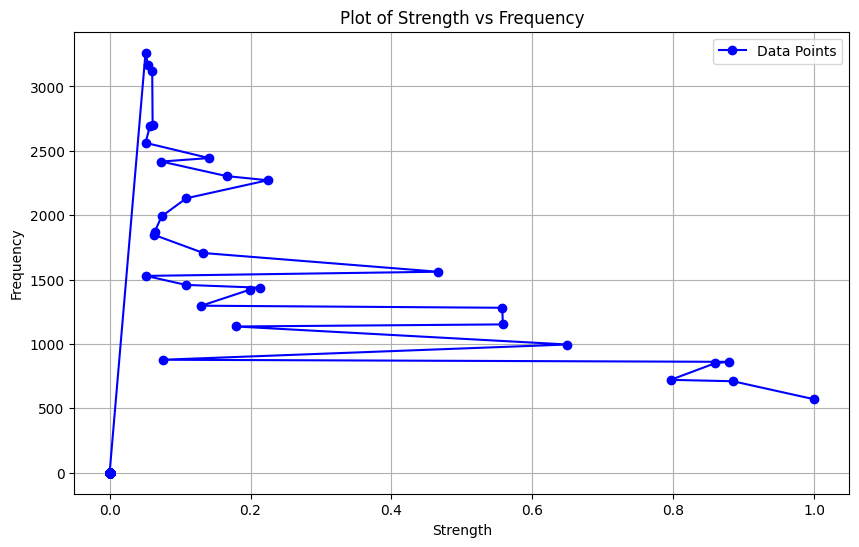

In [22]:
data = [point for point in first_array_restored if point != (0, 0)]

# Separate x and y values for plotting
x_values = [point[0] for point in first_array_restored]
y_values = [point[1] for point in first_array_restored]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label='Data Points')
plt.xlabel('Strength')
plt.ylabel('Frequency')
plt.title('Plot of Strength vs Frequency')
plt.grid(True)
plt.legend()
plt.show()